In [1]:
import pandas as pd
import numpy as np
from numpy.random import RandomState
import matplotlib.pyplot as plt
from tqdm import tqdm

seed = 42
rng = RandomState(seed)

df = pd.read_csv('./dataset/preprocessed.csv')

X, y = df.iloc[:, :-1], df.iloc[:, -1]
print(X.shape, y.shape)

(12599, 59) (12599,)


In [2]:
from sklearn.model_selection import train_test_split, cross_val_score

X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size=0.2, 
                                                    random_state=seed)
print('Train set: ', X_train.shape, y_train.shape)
print('Test set: ', X_test.shape, y_test.shape)

Train set:  (10079, 59) (10079,)
Test set:  (2520, 59) (2520,)


In [3]:
# Fill missing values
from sklearn.impute import SimpleImputer

imputer = SimpleImputer(strategy='most_frequent')
X_train = imputer.fit_transform(X_train)
X_test = imputer.transform(X_test)

In [4]:
# Train decision tree, random forest & SVM with their best params
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC

dt = DecisionTreeClassifier(criterion='entropy', max_depth=5, 
                            random_state=rng)
rf = RandomForestClassifier(criterion='entropy', n_estimators=100, 
                            random_state=rng)
sv = SVC(kernel='rbf', C=15.0)

dt.fit(X_train, y_train)
rf.fit(X_train, y_train)
sv.fit(X_train, y_train)

SVC(C=15.0)

In [5]:
dt_pred = dt.predict(X_test)
rf_pred = rf.predict(X_test)
sv_pred = sv.predict(X_test)

In [6]:
from sklearn.metrics import accuracy_score, roc_auc_score, plot_confusion_matrix

dt_acc = accuracy_score(y_test, dt_pred)
rf_acc = accuracy_score(y_test, rf_pred)
sv_acc = accuracy_score(y_test, sv_pred)

dt_auc = roc_auc_score(y_test, dt_pred)
rf_auc = roc_auc_score(y_test, rf_pred)
sv_auc = roc_auc_score(y_test, sv_pred)

print('Decision tree acc: %.6f' % dt_acc)
print('Random forest acc: %.6f' % rf_acc)
print('SVM acc: %.6f' % sv_acc)
print()
print('Decision tree AUC: %.6f' % dt_auc)
print('Random forest AUC: %.6f' % rf_auc)
print('SVM AUC: %.6f' % sv_auc)

Decision tree acc: 0.672222
Random forest acc: 0.751190
SVM acc: 0.747222

Decision tree AUC: 0.648482
Random forest AUC: 0.741907
SVM AUC: 0.737471


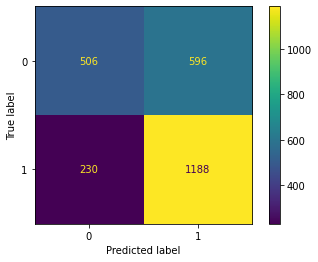

In [7]:
plot_confusion_matrix(dt, X_test, y_test)

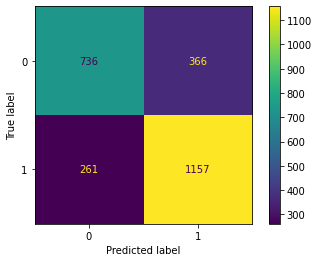

In [8]:
plot_confusion_matrix(rf, X_test, y_test)

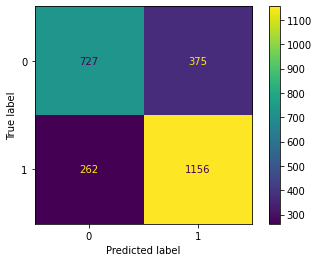

In [9]:
plot_confusion_matrix(sv, X_test, y_test)

In [10]:
coupon_type = ['Bar', 'Carry out & Take away', 'Coffee House', 
               'Restaurant(<20)', 'Restaurant(20-50)']
datasets = {}
for type_name in coupon_type:
    column_name = 'coupon_' + type_name
    data = df[df[column_name] == 1].copy()
    X, y = data.iloc[:, :-1], data.iloc[:, -1]
    
    # fill missing value
    X[:] = imputer.transform(X)
    
    X = X.drop(columns=['coupon_'+type_name for type_name in coupon_type])
    
    datasets[type_name] = (X, y)

In [11]:
# Cross validation on different type of coupon
# to compare with Bayesian rule sets
# from paper: https://jmlr.org/papers/v18/16-003.html

from sklearn.model_selection import cross_val_score
from sklearn.impute import SimpleImputer

estimators = [
    DecisionTreeClassifier(criterion='entropy', max_depth=5, 
                           random_state=rng),
    RandomForestClassifier(criterion='entropy', n_estimators=100,
                           random_state=rng),
    SVC(kernel='rbf', C=15.0)
]

for name, estimator in zip(['DT', 'RF', 'SVM'], estimators):
    print('---', name, '---')
    for coupon_type in datasets:
        X, y = datasets[coupon_type]
        scores = cross_val_score(
            estimator, X, y, cv=5, n_jobs=-1, scoring='roc_auc'
        )
        mean = scores.mean()
        std = scores.std()
        print('%-25s: %.3f(%.3f)' % (coupon_type, mean, std))
        

--- DT ---
Bar                      : 0.715(0.028)
Carry out & Take away    : 0.576(0.051)
Coffee House             : 0.707(0.050)
Restaurant(<20)          : 0.538(0.130)
Restaurant(20-50)        : 0.584(0.057)
--- RF ---
Bar                      : 0.712(0.029)
Carry out & Take away    : 0.627(0.069)
Coffee House             : 0.702(0.060)
Restaurant(<20)          : 0.518(0.138)
Restaurant(20-50)        : 0.589(0.035)
--- SVM ---
Bar                      : 0.700(0.026)
Carry out & Take away    : 0.614(0.055)
Coffee House             : 0.691(0.043)
Restaurant(<20)          : 0.566(0.063)
Restaurant(20-50)        : 0.583(0.012)
